In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import sounddevice as sd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import librosa
import tarfile
import os
import warnings
import random

In [14]:
tar_path = "D:/UrbanSound8K.tar.gz"
extract_to = "D:/Urban Dataset8K"
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_to)

In [15]:
data = pd.read_csv("D:/UrbanSound8K/metadata/UrbanSound8K.csv")
data

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


Feature Extraction

In [ ]:
#features stores MFCC features of each audio
features, labels = [], []

warnings.filterwarnings("ignore", category=UserWarning)

def extract_features(file_path):
    #kaiser_fast is a resampling algorithm that's fast and good for speed over perfect audio quality
    audio, sr = librosa.load(file_path, res_type='kaiser_fast') #Load audio file, sampling rate
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0) #Takes the mean over time, resulting in a 1D array of shape (40,)

for index, row in data.iterrows():
    file_path = os.path.join("D:/UrbanSound8K/audio", f"fold{row['fold']}", row["slice_file_name"]) #Constructs full path
    try:
        mfcc = extract_features(file_path) #Extract MFCCs
        features.append(mfcc)
        labels.append(row["classID"])
    
    except Exception as e:
        print(f"Error: {e}")

X, y = np.array(features), to_categorical(np.array(labels))

CNN Training

In [ ]:
#Used CNN because it's best for spectrogram-based classification
#RNNs would have slower training on this dataset and would be more prone to overfitting on short audio clips
X = (X - np.mean(X)) / np.std(X)
X = X[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape = (40, 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
model.save("UrbanSound8K_model.h5")

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2820 - loss: 1.9426 - val_accuracy: 0.5529 - val_loss: 1.3135
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5348 - loss: 1.3246 - val_accuracy: 0.6422 - val_loss: 1.0619
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6097 - loss: 1.1365 - val_accuracy: 0.6840 - val_loss: 0.9086
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.9728 - val_accuracy: 0.7401 - val_loss: 0.7988
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7006 - loss: 0.8754 - val_accuracy: 0.7710 - val_loss: 0.6986
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7305 - loss: 0.7881 - val_accuracy: 0.8042 - val_loss: 0.6332
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7541 - loss: 0.7236 - val_accuracy: 0.8180 - val_loss: 0.5944
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7686 - loss: 0.6629 - val_accuracy: 0.

In [18]:
# Evaluate model accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9332 - loss: 0.2322
Test Accuracy: 93.13%


In [19]:
def record_audio(duration=2, sr=22050):
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()
    return audio.flatten()

def predict(audio):
    mfcc = extract_features_from_array(audio)
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    mfcc = mfcc.reshape(1, 40, 1)
    prediction = model.predict(mfcc)
    return np.argmax(prediction), np.max(prediction)

def extract_features_from_array(audio, sr=22050):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# Record and Predict
audio = record_audio()
label, confidence = predict(audio)
print(f"Predicted class: {label}, confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted class: 9, confidence: 0.63


Plotting

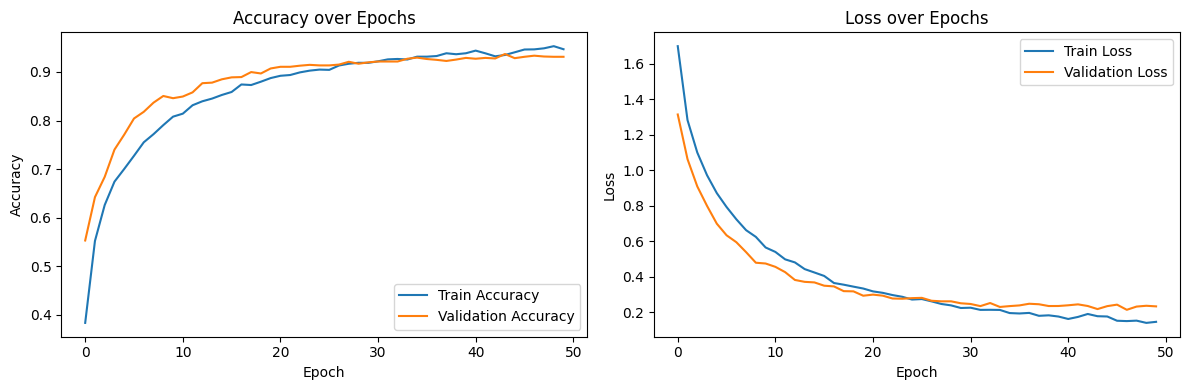

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

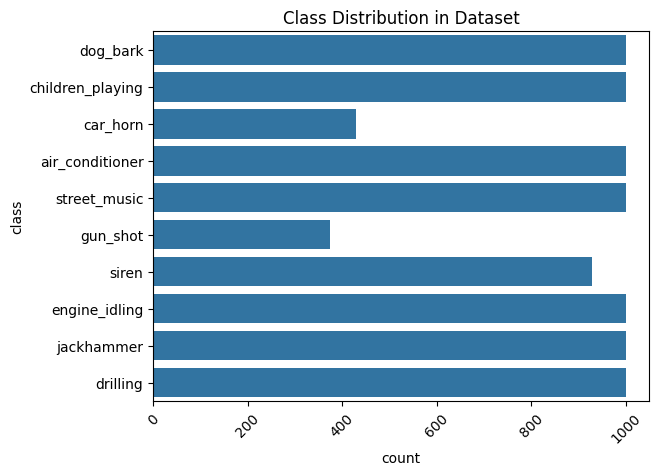

In [21]:
sns.countplot(data['class'])
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()

Using file: D:/UrbanSound8K/audio\fold10\99192-4-0-28.wav (Class: drilling)


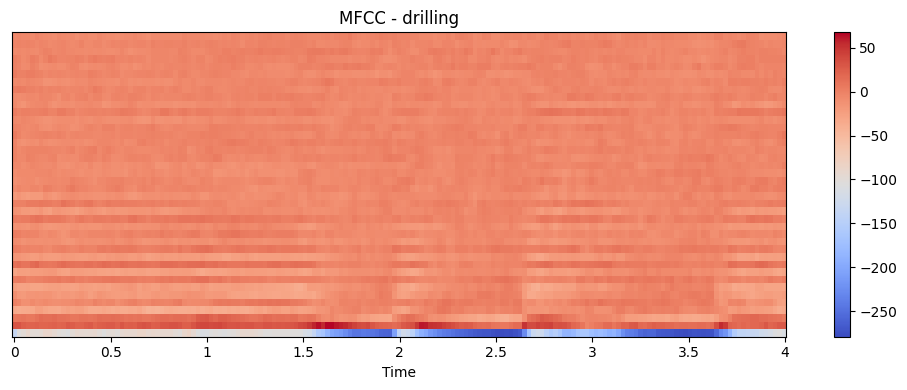

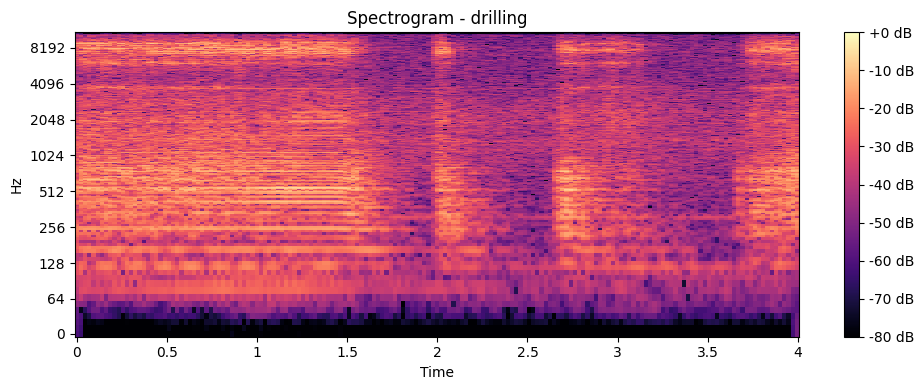

In [ ]:
# Pick a random sample
random_row = data.sample(1).iloc[0]
example_path = os.path.join("D:/UrbanSound8K/audio", f"fold{random_row['fold']}", random_row["slice_file_name"])
print(f"Using file: {example_path} (Class: {random_row['class']})")

# Load audio
y, sr = librosa.load(example_path)

# === 1. Plot MFCCs ===
plt.figure(figsize=(10, 4))
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f"MFCC - {random_row['class']}")
plt.tight_layout()
plt.show()

# === 2. Plot Spectrogram === frequencies of a signal as it varies with time
plt.figure(figsize=(10, 4))
spectrogram = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram - {random_row['class']}")
plt.tight_layout()
plt.show()